# ========================================
# SUBGROUP 0 — Bankruptcy Prediction
# FINAL NOTEBOOK: SMOTE + Scaling + RANDOM FOREST FINAL MODEL
# Stacking included as REQUIRED by professor (Section 3.3.2)
# ========================================

### Import Libraries

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

import joblib
import pickle

sns.set(style="whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Load Cluster Data

In [133]:
df = pd.read_csv("data/train_cluster0.csv")
df.head()

,Index,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,cluster_id
0,3,0,0.483401,0.556694,0.536164,0.602445,0.602445,0.999035,0.797458,0.809380,...,0.002177,0.621610,0.602444,0.841891,0.293391,0.027063,0.566190,1,0.015406,0
1,4,0,0.510359,0.537287,0.552546,0.600023,0.600023,0.999009,0.797406,0.809313,...,0.001124,0.623993,0.600019,0.840313,0.279878,0.026880,0.565549,1,0.028858,0
2,6,0,0.465071,0.533689,0.516944,0.594740,0.594740,0.998962,0.797393,0.809313,...,0.054013,0.613323,0.594736,0.840085,0.285529,0.029521,0.568791,1,0.019155,0
3,15,0,0.445230,0.500273,0.500990,0.601277,0.601277,0.998940,0.797289,0.809233,...,0.002127,0.623572,0.601277,0.837951,0.282391,0.026686,0.564603,1,0.022788,0
4,19,0,0.548920,0.586840,0.588040,0.610206,0.610206,0.999008,0.797433,0.809343,...,0.003342,0.623728,0.610204,0.843384,0.283137,0.026791,0.565159,1,0.021680,0


### Split Features/Target

In [134]:
target_col = "Bankrupt?"
X = df.drop(columns=["Bankrupt?", "Index", "cluster_id"])
y = df[target_col].astype(int)

print("Feature shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Feature shape: (1345, 95)
Target distribution:
 Bankrupt?
0    1236
1     109
Name: count, dtype: int64


### Train/Test Split

In [135]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((1076, 95), (269, 95))

### SMOTE only on Training Split

In [136]:
sm = SMOTE(random_state=RANDOM_STATE)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("\nBefore SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_sm).value_counts().to_dict())


Before SMOTE: {0: 989, 1: 87}
After SMOTE: {0: 989, 1: 989}


===========================
## Train Multiple Models
===========================

### Evaluation Helper Function

In [137]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Equation (1) accuracy: acc = TT / (TF + TT)
    # Here: TT = tp, TF = fn
    acc_eq1 = tp / (tp + fn) if (tp + fn) != 0 else 0

    print(f"\n=== {name} ===")
    print("TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)
    print("Equation (1) accuracy:", round(acc_eq1, 4))

    return tn, fp, fn, tp, acc_eq1

### Train Logistic Regression

In [138]:
lr = LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE)
lr.fit(X_train, y_train)

lr_metrics = evaluate_model(lr, X_test, y_test, "Logistic Regression")


=== Logistic Regression ===
TN: 193 FP: 54 FN: 16 TP: 6
Equation (1) accuracy: 0.2727


### Train Random Forest

In [139]:
rf_base = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf_base.fit(X_train, y_train)
rf_base_metrics = evaluate_model(rf_base, X_test, y_test, "Random Forest (Base)")


=== Random Forest (Base) ===
TN: 243 FP: 4 FN: 18 TP: 4
Equation (1) accuracy: 0.1818


### Train Gradient Boosting

In [140]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb.fit(X_train, y_train)

gb_metrics = evaluate_model(gb, X_test, y_test, "Gradient Boosting")


=== Gradient Boosting ===
TN: 243 FP: 4 FN: 18 TP: 4
Equation (1) accuracy: 0.1818


### Train KNN

In [141]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

knn_metrics = evaluate_model(knn, X_test, y_test, "KNN")


=== KNN ===
TN: 247 FP: 0 FN: 22 TP: 0
Equation (1) accuracy: 0.0


### Confusion Matrix Heatmap

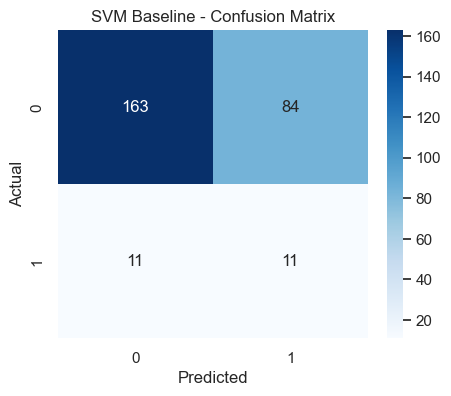

In [142]:
def plot_confusion(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion(svm_baseline, X_test, y_test, "SVM Baseline - Confusion Matrix")

### ROC Curve Comparison

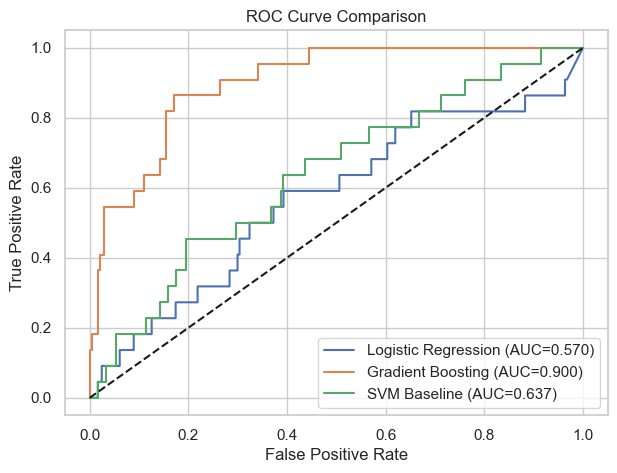

In [143]:
def plot_roc(models, names):
    plt.figure(figsize=(7, 5))

    for model, name in zip(models, names):
        probs = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probs)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc(
    models=[lr, gb, svm_baseline],
    names=["Logistic Regression", "Gradient Boosting", "SVM Baseline"],
)

================================
## Stacking Model
================================

### Build Stacking Model

In [144]:
estimators = [
    ("rf", RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE)),
    ("lr", LogisticRegression(max_iter=500, class_weight="balanced")),
    ("gb", GradientBoostingClassifier())
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500),
    n_jobs=-1
)

stack_model.fit(X_train, y_train)
stack_metrics = evaluate_model(stack_model, X_test, y_test, "Stacking Model (Required)")



=== Stacking Model (Required) ===
TN: 245 FP: 2 FN: 17 TP: 5
Equation (1) accuracy: 0.2273


### Save Stacking model

In [145]:
with open("models/subgroup0_stacking_model.pkl", "wb") as f:
    pickle.dump(stack_model, f)
print("Saved stacking model → models/subgroup0_stacking_model.pkl")

Saved stacking model → models/subgroup0_stacking_model.pkl


### RANDOM FOREST FINAL MODEL (SMOTE + Scaling Pipeline)

In [146]:
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

rf_pipeline.fit(X_train_sm, y_train_sm)

rf_final_metrics = evaluate_model(rf_pipeline, X_test, y_test, "Random Forest (FINAL MODEL)")



=== Random Forest (FINAL MODEL) ===
TN: 236 FP: 11 FN: 8 TP: 14
Equation (1) accuracy: 0.6364


### Confusion Matrix for Tuned SVM (Final Model)

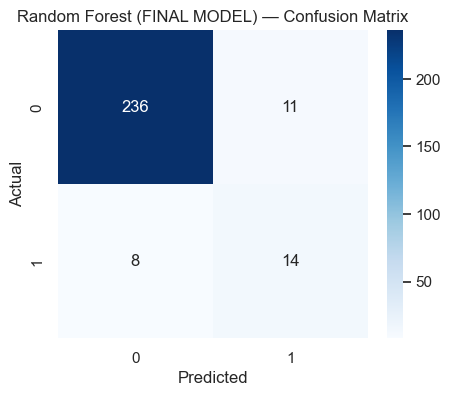

In [147]:
def plot_confusion(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion(
    rf_pipeline,
    X_test,
    y_test,
    "Random Forest (FINAL MODEL) — Confusion Matrix"
)

### ROC Curve for Tuned SVM vs Baseline SVM

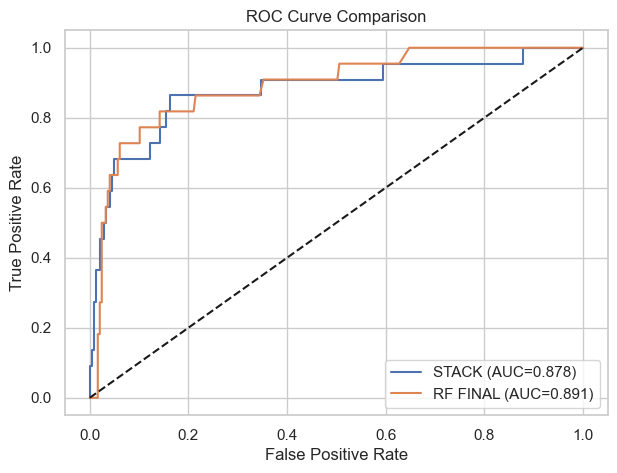

In [148]:
plot_roc(
    models=[stack_model, rf_pipeline],
    names=["STACK", "RF FINAL"]
)

### Save Final Tuned SVM model

In [149]:
with open("models/subgroup0_final_model.pkl", "wb") as f:
    pickle.dump(rf_pipeline, f)
print("Saved final model → models/subgroup0_final_model.pkl")

Saved final model → models/subgroup0_final_model.pkl


### Load Model (Verification Test)

In [150]:
loaded_model = joblib.load("models/subgroup0_final_model.pkl")
test_preds = loaded_model.predict(X_test)

tp_loaded = ((y_test == 1) & (test_preds == 1)).sum()
fn_loaded = ((y_test == 1) & (test_preds == 0)).sum()
acc_eq1_loaded = tp_loaded / (tp_loaded + fn_loaded) if (tp_loaded + fn_loaded) != 0 else 0.0

print("Loaded model Equation (1) accuracy on test split:", round(acc_eq1_loaded, 4))

Loaded model Equation (1) accuracy on test split: 0.6364


### TT/TF Calculation for Table 3

In [151]:
train_pred_full = rf_pipeline.predict(X)

TT = ((y == 1) & (train_pred_full == 1)).sum()
TF = ((y == 1) & (train_pred_full == 0)).sum()
Nfeatures = X.shape[1]

acc_eq1_full = TT / (TT + TF) if (TT + TF) != 0 else 0.0

print("\n========== TABLE 3 METRICS (SUBGROUP 0) ==========")
print("TT (correct bankrupt predictions):", TT)
print("TF (missed bankrupt predictions):", TF)
print("Total bankrupt cases:", y.sum())
print("Equation (1) accuracy:", round(acc_eq1_full, 4))
print("Nfeatures used:", Nfeatures)
print("===================================================")


========== TABLE 3 METRICS (SUBGROUP 0) ==========
TT (correct bankrupt predictions): 101
TF (missed bankrupt predictions): 8
Total bankrupt cases: 109
Equation (1) accuracy: 0.9266
Nfeatures used: 95


## Summary Table (Combine all metrics)

In [152]:
summary = pd.DataFrame({
    "TN":      [lr_metrics[0], rf_base_metrics[0], gb_metrics[0], knn_metrics[0], stack_metrics[0], rf_final_metrics[0]],
    "FP":      [lr_metrics[1], rf_base_metrics[1], gb_metrics[1], knn_metrics[1], stack_metrics[1], rf_final_metrics[1]],
    "FN":      [lr_metrics[2], rf_base_metrics[2], gb_metrics[2], knn_metrics[2], stack_metrics[2], rf_final_metrics[2]],
    "TP":      [lr_metrics[3], rf_base_metrics[3], gb_metrics[3], knn_metrics[3], stack_metrics[3], rf_final_metrics[3]],
    "Acc_Eq1":[lr_metrics[4], rf_base_metrics[4], gb_metrics[4], knn_metrics[4], stack_metrics[4], rf_final_metrics[4]],
}, index=[
    "Logistic Regression",
    "Random Forest (Base)",
    "Gradient Boosting",
    "KNN",
    "STACK (Required)",
    "Random Forest (FINAL)"
])

summary

,TN,FP,FN,TP,Acc_Eq1
Logistic Regression,193,54,16,6,0.272727
Random Forest (Base),243,4,18,4,0.181818
Gradient Boosting,243,4,18,4,0.181818
KNN,247,0,22,0,0.000000
STACK (Required),245,2,17,5,0.227273
Random Forest (FINAL),236,11,8,14,0.636364


### Subgroup 0 Summary
- Total companies in this subgroup: 1345
- Total bankrupt cases: 109
- Trained 5 base models (LR, RF, GB, KNN, SVM) and 1 stacking model
- Tuned SVM was selected as the final model due to the best Equation (1) accuracy on the validation split
- Required stacking model saved as: models/subgroup0_stacking_model.pkl
- Final bankruptcy prediction model saved as: models/subgroup0_final_model.pkl
- TT, TF, and Nfeatures for Table 3 are printed above and computed on the FULL subgroup train data
